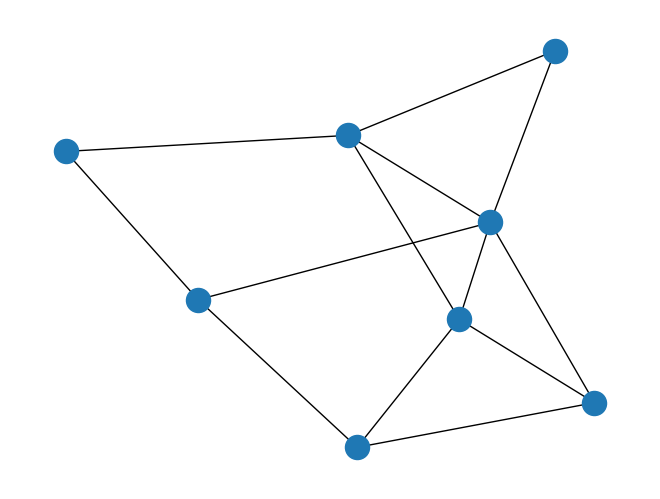

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ensure reproducibility
seed = 10
np.random.seed(seed)

n_nodes = 8
edge_prob = 0.5
graph = nx.gnp_random_graph(n_nodes, edge_prob)

nx.draw(graph)


# Problem (Maximal Cut)

Find the partition $p$ of the graph that maximizes the number of edges between the two subgraphs.

Formally, maximize:

$$\mathcal{C}(p) = \sum_{\alpha \in edges} \mathcal{C}_{\alpha}(p)$$

where:

- $\mathcal{C}_{\alpha}(p)$ is $0$ if the nodes connected by edge $\alpha$ are in the same set, as defined by $p$;
- $\mathcal{C}_{\alpha}(p)$ is $1$ if the nodes connected by edge $\alpha$ are in distinct sets, as defined by $p$.

In [2]:
from qadence import Zero, I, HamEvo, tag, kron, chain, QuantumCircuit, RX, Z

# generators associated with the edges of the given graph
zz_ops = [kron(Z(edge[0]), Z(edge[1])) for edge in graph.edges()]

n_qubits = graph.number_of_nodes()
n_layers = 2

cost_ham = Zero()
for op in zz_ops:
    cost_ham += 0.5 * op
cost_ham = 0.5 * kron(I(i) for i in range(n_qubits)) - cost_ham

layers = []
for layer in range(n_layers):

    # cost layer with digital decomposition
    cost_layer = HamEvo(cost_ham, f"g{layer}").digital_decomposition()
    cost_layer = tag(cost_layer, "cost")

    # mixing layer with single qubit rotations
    mixing_layer = kron(RX(i, f"b{layer}{i}") for i in range(n_qubits))
    mixing_layer = tag(mixing_layer, "mixing")

    # putting all together in a single ChainBlock
    layers.append(chain(cost_layer, mixing_layer))

final_b = chain(*layers)

circuit = QuantumCircuit(n_qubits, final_b)



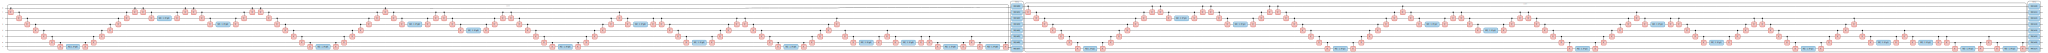

In [3]:
from qadence.draw import display
display(circuit)